In [ ]:
"""
We will integrate the gene expression and cell-based metadata into a single AnnData object
We will use snRNA-seq data from ROS/MAP cohort, used in Mathys etal Nature.
Its data from XX donors in the AD continuum, obrained in the Dorso-Lateral pre-Frontal Cortex

Synapse id: syn21589957

Info on the pipeline used to obtain gene counts can be found here:
   https://www.synapse.org/#!Synapse:syn16780177
   
The metadata include, for each cell, the major cell-type and the subsequent sub-types.
"""

In [1]:
# IMPORT LIBRARIES
# ================
import os
from os.path import join

import gc   # garbage collector
import pdb

import numpy as np
from scipy.sparse import csr_matrix
import pandas as pd

import anndata as ad
import scanpy as sc



In [2]:
# LOAD DATA FILES
# ===============
ipath = "/data/theshire/Users/vmontalb/student/2022-Alexandra-UOC/scRNA-AD/data"
opath = "/data/theshire/Users/vmontalb/student/2022-Alexandra-UOC/scRNA-AD/anndata"

iexpr = join(ipath,"ROSMAP_Brain.snRNAseq_counts_sparse_format_20201107.csv")
imetadata = join(ipath,"ROSMAP_Brain.snRNAseq_metadata_cells_20201107.csv")
igenename = join(ipath,"ROSMAP_Brain.snRNAseq_metadata_genes_20201107.csv")

# Load metadata
print(f'Load metadata')
metadf = pd.read_csv(imetadata)
numsubj = metadf.shape[0]
print(f'  Number cells: {numsubj}')

genedf = pd.read_csv(igenename)
numgenes = genedf.shape[0]
print(f'  Number genes: {numgenes}')

# Load gene count
"""
The .csv file is stored in a sparse format. Thus we will first load a dataframe, and use the columns to create
a scipy sparse matrix. From there, to a numpy array
"""
print(f'Load gene expression counts')
numsubj = metadf.shape[0]
numgenes = genedf.shape[0]
expdf = pd.read_csv(iexpr, delimiter=",")

cols = expdf["i"].values  -  1     # Gene position // # We extract 1 b/c python index starts at 0, not 1
rows = expdf["j"].values  -  1     # Cell position // # We extract 1 b/c python index starts at 0, not 1  
data = expdf["x"].values

genemat = csr_matrix((data, (rows, cols)), shape=(numsubj, numgenes)).toarray()
print(f' Gene exp count mat shape: {genemat.shape}')

# Remove temporary files (memory issues)
del(expdf)
del(cols)
del(rows)
del(data)
gc.collect()

Load metadata
  Number cells: 162767
  Number genes: 23241
Load gene expression counts
 Gene exp count mat shape: (162767, 23241)


0

In [3]:
# GENERATE ANNDATA
# ================
print(f'Generate AnnData')
annout = ad.AnnData(genemat, dtype=int)   # init AnnData object

annout.obs_names = [idx for idx in metadf["cell_name"].values] 
annout.var_names = [idx for idx in genedf['x'].values]

print(f'Add metadata to AnnData')
annout.obs['speciment_ID'] = metadf["specimenID"].values
annout.obs['major_cell_type'] = metadf["broad_class"].values
annout.obs['subtype_cell_type'] = metadf["subtype"].values

annout.var["geneID"] = genedf['x'].values


print(f'Subset AnnData to reduce RAM memory requirements')
filt_types = {"Exc.Exc.L3" : 5,
              "Astr.1" : 4,
              "Olig.1" : 3,
              "Exc.Exc.L5" : 3, 
              "Exc.Exc.RORB_L5_IT_2" : 3,
              "Olig.2" : 3,
              "Olig.3" : 3,
              "OPC.NA" : 2,
              "Inh.Inh.PVALB_not_chandelier" : 2,
              "Inh.Inh.VIP" : 2,
              "Inh.Inh.SST" : 2,
              "Astr.2" : 2,
              "Olig.4" : 2}

filt_idx = list()
for ccell in filt_types:
    poscell = np.where(annout.obs['subtype_cell_type'].values  ==  ccell)[0]
    setlength = np.round( poscell.size / filt_types[ccell]).astype(int)
    randset = np.random.choice(poscell,size=setlength, replace=False)
    filt_idx.extend(randset)

filt_idx = np.in1d(range(numsubj),np.array(filt_idx))
filt_anndat = annout[~filt_idx,:]

    
print(f'Save AnnData')
ofile = join(opath,"snRNA-AD.h5ad")
#filt_anndat.write(ofile)
filt_anndat.write(ofile, compression="gzip")  # Might take a while b/c we are compressing the file

Generate AnnData
Add metadata to AnnData
Subset AnnData to reduce RAM memory requirements
Save AnnData


/home/vmontalb/.conda/python/py38/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/vmontalb/.conda/python/py38/lib/python3.8/contextlib.py:120: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


In [1]:
anndat.obs

NameError: name 'anndat' is not defined

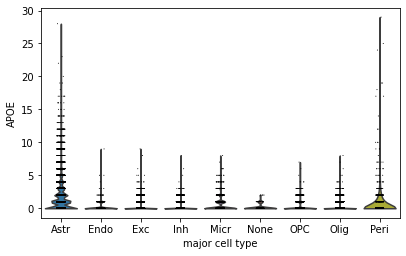

/home/vmontalb/.conda/python/py38/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/vmontalb/.conda/python/py38/lib/python3.8/contextlib.py:120: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


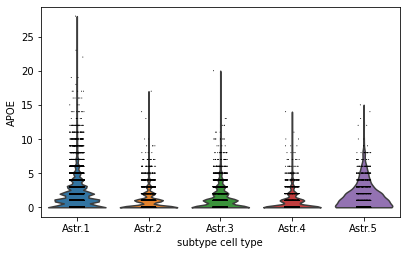

In [12]:
# EXAMPLE PLOTTING
# ================
# Plot expression APOE by major type
sc.pl.violin(filt_anndat, keys=['APOE'], groupby="major_cell_type")

# Plot expression APOE by subtypes of ONLY astrocite
tmpadat = annout[filt_anndat.obs["major_cell_type"] == "Astr",:]
# Plot expression APOE by major type
sc.pl.violin(filt_anndat, keys=['APOE'], groupby="subtype_cell_type")